In [8]:
import cv2
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import numpy as np
import math
import cmath
from scipy import ndimage
from scipy import optimize
from scipy import signal
from scipy import interpolate
from scipy.signal import find_peaks
from skimage.measure import profile_line
import pandas as pd

%matplotlib inline
# matplotlibのスタイル設定
plt.rcParams['figure.figsize'] = [4.8*2, 4.8*1]  # (default: [6.4, 4.8])
# plt.rcParams["font.family"] = "Times New Roman"      #全体のフォントを設定
plt.rcParams["xtick.direction"] = "in"               #x軸の目盛線を内向きへ
plt.rcParams["ytick.direction"] = "in"               #y軸の目盛線を内向きへ
plt.rcParams["xtick.minor.visible"] = True           #x軸補助目盛りの追加
plt.rcParams["ytick.minor.visible"] = True           #y軸補助目盛りの追加
# plt.rcParams["xtick.major.width"] = 1.5              #x軸主目盛り線の線幅
# plt.rcParams["ytick.major.width"] = 1.5              #y軸主目盛り線の線幅
# plt.rcParams["xtick.minor.width"] = 1.0              #x軸補助目盛り線の線幅
# plt.rcParams["ytick.minor.width"] = 1.0              #y軸補助目盛り線の線幅
# plt.rcParams["xtick.major.size"] = 10                #x軸主目盛り線の長さ
# plt.rcParams["ytick.major.size"] = 10                #y軸主目盛り線の長さ
# plt.rcParams["xtick.minor.size"] = 5                 #x軸補助目盛り線の長さ
# plt.rcParams["ytick.minor.size"] = 5                 #y軸補助目盛り線の長さ
plt.rcParams["font.size"] = 14                       #フォントの大きさ
# plt.rcParams["axes.linewidth"] = 1.5                 #囲みの太さ
# plt.style.use('fast')

# カメラID or ファイル名から画像取得
def CapturedImage(camera_id, rotateTF, im_plotTF):
    if isinstance(camera_id, int): # 整数？
        cap = cv2.VideoCapture(camera_id)
    #     cap = cv2.VideoCapture('http://192.168.0.3:8080/video')
        ret, im = cap.read()
        cap.release()
    elif os.path.exists(camera_id): # ファイル存在？
        im = cv2.imread(camera_id)  # 画像ファイル取得
    else:
        sys.exit()
    # 白黒
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    if rotateTF:
        # 時計回りに回転
        im_gray = cv2.rotate(im_gray, cv2.ROTATE_90_CLOCKWISE)
    # ガウシアンフィルタによる平滑化
#     im_gray = cv2.GaussianBlur(im_gray, (1, 51), 10)
    # 単純二値化
#     ret, im_gray = cv2.threshold(im_gray, 0, 255, cv2.THRESH_OTSU)
    if im_plotTF:
        # print("Image size: ", im_gray.shape)
        # イメージプロット
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_aspect('equal')
        ax.imshow(im_gray, cmap="gray", vmin=0, vmax=255)
        ax.set_xlabel('pixel $X$')
        ax.set_ylabel('pixel $Y$')
        ax.set_title('Captured digital image: ('
                     +str(im_gray.shape[0])+', '+str(im_gray.shape[1])+')')
        # ax.set_xlim( 1500, 2000 )
        # ax.set_ylim( 1000, 1500 )
        plt.show()
    return im_gray

# 矩形型格子ラインプロファイルから格子ピッチを求めるための関数
# 微分（各点の差）データからピーク検出してエッジを見つけている
# 返り値は，矩形の中点に対応するindex値
def BoxLinprofToMaxIndex(pixel, lineprofile, peakdistance, plotTF):
    diffProf = np.diff(lineprofile)
    findpeakheight = np.mean(np.abs(diffProf[4:-4:]))*1.5
    # print(findpeakheight)
    # 導関数のプラス側ピーク検出
    diffProf_p = np.where( diffProf < 0, 0, diffProf ) # マイナス値をゼロに
    diffProf_pPeakIndex, _ = find_peaks(
        diffProf_p, height=findpeakheight, distance=peakdistance)
    # 導関数のマイナス側ピーク検出
    diffProf_m = np.where( diffProf > 0, 0, diffProf ) # プラス値をゼロに
    diffProf_mPeakIndex, _ = find_peaks(
        -1*diffProf_m, height=findpeakheight, distance=peakdistance)
    # ピーク点を整理して，そこから矩形の中点を求める
    if diffProf_pPeakIndex[0] > diffProf_mPeakIndex[0]:
        diffProf_mPeakIndex = diffProf_mPeakIndex[1::]
    if not len(diffProf_pPeakIndex) == len(diffProf_mPeakIndex):
        diffProf_pPeakIndex = diffProf_pPeakIndex[:-1:]
    if plotTF: # abs(diff) & ピーク検出をプロットして確認？
        fig, ax = plt.subplots(figsize=(10, 2))
        ax.set_title('check findpeak')
        ax.plot(pixel[:-1:], np.abs(diffProf))
        ax.scatter(pixel[diffProf_pPeakIndex], 
                   np.abs(diffProf)[diffProf_pPeakIndex],
                   color='b', label='peak', zorder=10)
        ax.scatter(pixel[diffProf_mPeakIndex], 
                   np.abs(diffProf)[diffProf_mPeakIndex],
                   color='g', label='peak', zorder=10)
        plt.show()    
    return ((diffProf_pPeakIndex+diffProf_mPeakIndex )/2).astype('int64')

# イメージから使用する部分をトリミングして，平滑化
# さらに水平(H)と垂直(V)の使用部分をトリミングしたものを返す
def ImageHVTrim(im_gray, center, length, linewidth, GaussConst, plotTF):
    (centerX, centerY) = center
    (lengthX, lengthY) = length
    Trim_StartPnt = {'y':centerY-int(lengthY/2), 'x':centerX-int(lengthX/2)}
    Trim_EndPnt   = {'y':centerY+int(lengthY/2), 'x':centerX+int(lengthX/2)}
    im_Trim = im_gray[Trim_StartPnt['y']:Trim_EndPnt['y'], # y 範囲
                      Trim_StartPnt['x']:Trim_EndPnt['x']] # x 範囲
    # print(im_Trim.shape)
    # 水平トリミング範囲
    TrimH_StartPnt = {'y':int((im_Trim.shape[0]/2)-(linewidth/2)), 'x':0}
    TrimH_EndPnt   = {'y':int((im_Trim.shape[0]/2)+(linewidth/2)), 'x':im_Trim.shape[1]}
    # 垂直トリミング範囲
    TrimV_StartPnt = {'y':0,                'x':int((im_Trim.shape[1]/2)-(linewidth/2))}
    TrimV_EndPnt   = {'y':im_Trim.shape[0], 'x':int((im_Trim.shape[1]/2)+(linewidth/2))}
    # im_Vtrim = cv2.rotate(im_Vtrim, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if plotTF:
        fig, ax = plt.subplots(1,2,figsize=(6*2, 6))
        ax[0].set_aspect('equal')
        ax[0].imshow(im_gray, cmap="gray", vmin=0, vmax=255)
        Trimbox = patches.Rectangle(
            xy=(Trim_StartPnt['x'], Trim_StartPnt['y']), 
            width=lengthX, height=lengthY, ec='k', lw=3, fill=False)
        ax[0].add_patch(Trimbox)
        ax[0].scatter(centerX, centerY, marker="x", c='k')
        ax[0].set_xlabel('pixel $X$')
        ax[0].set_ylabel('pixel $Y$')
        ax[0].set_title('Captured image: ('
                     +str(im_gray.shape[0])+', '+str(im_gray.shape[1])+')')
        ax[1].imshow(im_Trim, cmap="gray", vmin=0, vmax=255)
        TrimHbox = patches.Rectangle(
            xy=(TrimH_StartPnt['x'], TrimH_StartPnt['y']), 
            width=lengthX, height=linewidth, ec='r', lw=3, fill=False)
        TrimVbox = patches.Rectangle(
            xy=(TrimV_StartPnt['x'], TrimV_StartPnt['y']), 
            width=linewidth, height=lengthY, ec='b', lw=3, fill=False)
        ax[1].add_patch(TrimHbox)
        ax[1].add_patch(TrimVbox)
        ax[1].set_title('Cropped image: ('
                     +str(im_Trim.shape[0])+', '+str(im_Trim.shape[1])+')')
        plt.show()
    # 垂直平滑化 & 水平トリミング
    im_Trim_VGauss = cv2.GaussianBlur(im_Trim, (1, GaussConst), GaussConst)
    im_Htrim = im_Trim_VGauss[TrimH_StartPnt['y']:TrimH_EndPnt['y'], # y 範囲
                              TrimH_StartPnt['x']:TrimH_EndPnt['x']] # x 範囲
    # 水平平滑化 & 垂直トリミング & 反時計回りに回転
    im_Trim_HGauss = cv2.GaussianBlur(im_Trim, (GaussConst, 1), GaussConst)
    im_Vtrim = im_Trim_HGauss[TrimV_StartPnt['y']:TrimV_EndPnt['y'], # y 範囲
                              TrimV_StartPnt['x']:TrimV_EndPnt['x']] # x 範囲
    im_Vtrim = cv2.rotate(im_Vtrim, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return (im_Htrim, im_Vtrim)

# 1次元ラインプロファイルから格子平均ピッチとサンプリングピッチ出力
def LineprofileToPich(Lineprofile, plotTF):
    # ピッチを求める
    peakdistance = 1
    maxIndex = BoxLinprofToMaxIndex(
        np.arange(len(Lineprofile)), Lineprofile, peakdistance, plotTF)
    GratingPich = np.mean(np.diff(maxIndex))
    SamplingPitch = int(GratingPich*0.98) # サンプリングピッチ
    return (GratingPich, SamplingPitch)

# トリミング格子画像から最初の補間処理までの確認
def ShowInterpolationProcess(im_trim):
    # 平均化して1次元化
    Lineprofile = np.mean(im_trim, axis=0)
    Lineprofile_i = np.arange(len(Lineprofile))
    (GratingPich, SamplingPitch) = LineprofileToPich(Lineprofile, 0)

    MoireFringe_i = Lineprofile_i[0::SamplingPitch]
    MoireFringe = Lineprofile[MoireFringe_i] # 間引きサンプリング
    # Interp_kind = "quadratic" # 2次スプライン補間
    Interp_kind = "cubic"  # 3次スプライン補間
    MoireInterpolate = interpolate.interp1d(
        MoireFringe_i, MoireFringe, kind=Interp_kind, fill_value="extrapolate")

    plotrow = 3
    fig = plt.figure(figsize=(5*2, 5*plotrow/2), tight_layout=True)
    # ---- original grating 
    ax1 = fig.add_subplot(plotrow, 1, 1)
    ax1.set_yticklabels([]) # 目盛りラベル削除
    ax1.tick_params(axis='y', which='both', length=0) # 目盛り削除
    ax1.set_title('the smoothed original grating')
    ax1.imshow(im_trim, cmap="gray", aspect='auto', origin='lower', vmin=0, vmax=255)

    ax2 = fig.add_subplot(plotrow, 1, 2, sharex=ax1)
    ax2.plot(Lineprofile, zorder=9)
    maxIndex = BoxLinprofToMaxIndex(
        Lineprofile_i, Lineprofile, 1, 0)
    ax2.scatter(Lineprofile_i[maxIndex], Lineprofile[maxIndex],
                color='r', label='box center', zorder=10)
    ax2.set_xlim(0, len(Lineprofile)-1)
    ax2.set_title('the mean intensity of the original grating (grating pitch = '
                  + str(np.round(GratingPich, 3))+')')

    ax3 = fig.add_subplot(plotrow, 1, 3, sharex=ax1)
    ax3.set_title('thinning-out & ' + Interp_kind
                  + ' interpolation (sampling pitch = '
                  + str(SamplingPitch)+')')
    ax3.plot(Lineprofile_i, Lineprofile, zorder=1)
    ax3.scatter(MoireFringe_i, MoireFringe,
                color='r', label='max', zorder=10)
    ax3.plot(Lineprofile_i, MoireInterpolate(Lineprofile_i),
             lw=5, alpha=0.3, color='r', zorder=9)
    ax3.set_xlabel('pixel $i$')
    plt.show()

# 位相解析のためのFFT (DFT)の関数
def DFT(Im):
    p_s = len(Im)
    Im_k = np.array([Im[k] * np.e**( -2j * np.pi * ( k / p_s ))
                     for k in range(p_s)])
    return np.sum(Im_k)

# 1次元格子データとサンプリングピッチから位相解析をして位相を返す
def LineprofileToPhase(Lineprofile, SamplingPitch, plotTF):
    Lineprofile_i = np.arange(len(Lineprofile))
    # ---- 間引き処理 & 補間
    Interp_kind = "cubic"  # 3次スプライン補間
    # Interp_kind = "quadratic" # 2次スプライン補間
    MoireInterpolates = []
    for start_i in range(SamplingPitch):
        MoireFringe_i = Lineprofile_i[start_i::SamplingPitch]
        MoireFringe = Lineprofile[MoireFringe_i]
        MoireInterpolate = interpolate.interp1d(
            MoireFringe_i, MoireFringe, kind=Interp_kind, fill_value="extrapolate")
        MoireInterpolates.append(MoireInterpolate(Lineprofile_i))
    MoireInterpolates = np.array(MoireInterpolates)
    if plotTF:
        fig, axes = plt.subplots(nrows=SamplingPitch, figsize=(5*2, len(MoireInterpolates)*0.2))
        fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
        axes[0].set_title('the phase-shifted images of the moiré fringes, $I_m(i;k)$')
        vmax = np.max(MoireInterpolates)*1.02
        for i, (ax, MoireInterp_i) in enumerate(zip(axes, MoireInterpolates)):
            temp = np.vstack([MoireInterp_i, MoireInterp_i])
            ax.imshow(temp, aspect='auto', cmap="gray", vmax=vmax)
            pos = list(ax.get_position().bounds)
            x_text = pos[0] - 0.01
            y_text = pos[1] + pos[3]/2.
            fig.text(x_text, y_text, "k = "+str(i), va='center', ha='right', fontsize=10)
        for ax in axes:
            ax.set_axis_off()
        plt.show()
    phi = [cmath.phase(DFT(MoireInterpolates[:,i]))
       for i in Lineprofile_i]
    # print(phi)
    if plotTF:
        fig = plt.figure(figsize=(5*2, 5*0.7))
        spec = gridspec.GridSpec(ncols=1, nrows=2,
                                 height_ratios=[1, 4])
        ax0 = fig.add_subplot(spec[0])
        ax0.set_title('the result of phase analysis, $\phi_m(i)$')
        phi_temp = np.vstack([phi, phi])
        ax0.imshow(phi_temp, aspect='auto', cmap="gray", vmin=-np.pi, vmax=np.pi)
        ax0.set_axis_off()
        ax1 = fig.add_subplot(spec[1])
        ax1.set_title('')
        ax1.plot(Lineprofile_i, phi, zorder=1)
        ax1.set_xlim(0, len(Lineprofile_i)-1)
        ax1.set_xlabel('pixel $i$')
        ax1.set_ylabel('$\phi_m(i)$')
        plt.show()
    return phi

In [9]:
# 引数：取得画像，トリミング情報，（格子ピッチ，サンプリングピッチ）
# 返り値：位相，格子ピッチ，サンプリングピッチを返す
# 最初の実行のときは，格子ピッチ，サンプリングピッチは(0, 0)を入れる
def ImageToPhase(camera_id, rotateTF, center, length, linewidth, GaussConst, GratingPich, SamplingPitch, allplotTF):
    (centerX, centerY) = center
    (lengthX, lengthY) = length
    im_gray = CapturedImage(camera_id, rotateTF, allplotTF)
    (im_Htrim, im_Vtrim) = ImageHVTrim(
        im_gray, (centerX, centerY), (lengthX, lengthY), linewidth, GaussConst, allplotTF)
    if SamplingPitch == (0, 0): # サンプリングピッチが未決定（基準測定）のとき
        (GratingPich_H, SamplingPitch_H) = LineprofileToPich(np.mean(im_Htrim, axis=0), allplotTF)
        (GratingPich_V, SamplingPitch_V) = LineprofileToPich(np.mean(im_Vtrim, axis=0), allplotTF)
    else:
        (SamplingPitch_H, SamplingPitch_V) = SamplingPitch
        (GratingPich_H, GratingPich_V) = GratingPich
    phi_H = LineprofileToPhase(np.mean(im_Htrim, axis=0), SamplingPitch_H, allplotTF)
    phi_V = LineprofileToPhase(np.mean(im_Vtrim, axis=0), SamplingPitch_V, allplotTF)
    return ((phi_H, phi_V), (GratingPich_H, GratingPich_V), (SamplingPitch_H, SamplingPitch_V))

# 変位前と変位後の位相から変位量を出力
def PhaseToDisplacement(unmove_phi, move_phi, GratingPich, plotTF):
    # 位相差
    Delta_phi = np.array(move_phi)-np.array(unmove_phi)
    # 位相差を-piからpiの間に変換
    Delta_phi = np.arctan2(np.sin(Delta_phi), np.cos(Delta_phi))
    if plotTF:
        fig = plt.figure(figsize=(5*2, 5*0.7))
        spec = gridspec.GridSpec(ncols=1, nrows=2,
                                 height_ratios=[1, 4])
        ax0 = fig.add_subplot(spec[0])
        ax0.set_title('the phase difference of the moiré fringe, $\overline{\Delta \phi_m(i)} = $'
                      +str(np.round(np.average(Delta_phi),3)))
        temp = np.vstack([Delta_phi, Delta_phi])
        ax0.imshow(temp, aspect='auto', cmap="gray", vmin=-np.pi, vmax=np.pi)
        ax0.set_axis_off()
        ax1 = fig.add_subplot(spec[1])
        ax1.set_title('')
        ax1.plot(Delta_phi, zorder=1)
        ax1.set_xlim(0, len(Delta_phi)-1)
        ax1.set_xlabel('pixel $i$')
        ax1.set_ylabel('$\Delta \phi_m(i)$')
        plt.show()
    # 両端20%のデータを削除
    cut=0.2
    Delta_phi = Delta_phi[0+int(cut*len(Delta_phi)):
                          (len(Delta_phi)-1)-int(cut*len(Delta_phi)):]
    return (GratingPich/(2*np.pi))*np.average(Delta_phi)

In [10]:
# ---------------------------
allplotTF = 1 # 全プロット表示・非表示
camera_id = 'TestImage/IMG_2779.jpg' # カメラID or ファイル名
rotateTF = 1 # 画像回転？
# ---------------------------
im_gray = CapturedImage(camera_id, rotateTF, 0)

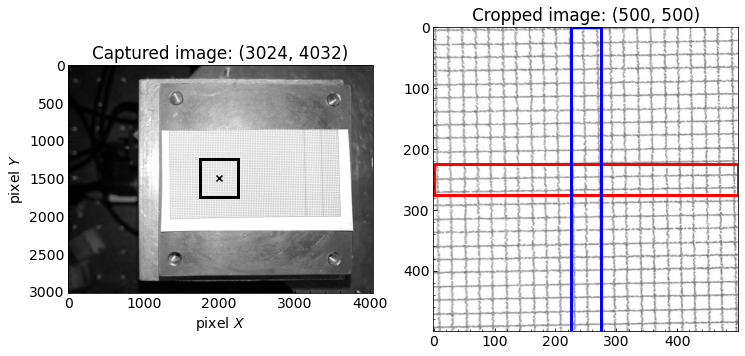

In [11]:
# ---------------------------
centerX, centerY = 2000, 1500  # サンプリングのセンターピクセル指定
lengthX = 500
lengthY = lengthX
linewidth = 50
GaussConst = 55 # 平滑化のための定数
# ---------------------------
(im_Htrim, im_Vtrim) = ImageHVTrim(
    im_gray, (centerX, centerY), (lengthX, lengthY), linewidth, GaussConst, allplotTF)

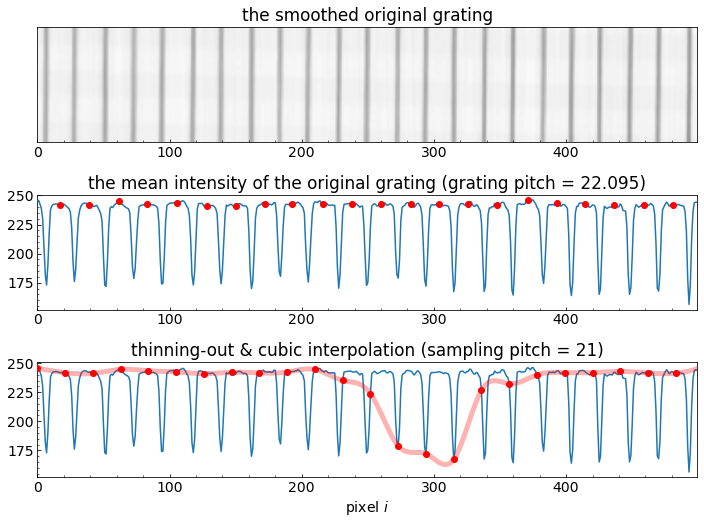

In [12]:
(GratingPich_H, SamplingPitch_H) = LineprofileToPich(np.mean(im_Htrim, axis=0), 0)
if allplotTF: ShowInterpolationProcess(im_Htrim)
(GratingPich_V, SamplingPitch_V) = LineprofileToPich(np.mean(im_Vtrim, axis=0), 0)
# if allplotTF: ShowInterpolationProcess(im_Vtrim)

$
{\rm phase\ analysis:\ } {\varphi_m}(i) 
= \varphi (i) - {\varphi_s}(i) 
= \arg \left[ {\sum\limits_{{k = 0}}^{{{p_s} - 1}} {{I_m}(i;k){ \exp }\left( { - 2j\pi \frac{k}{{{p_s}}}} \right)} } \right]
$

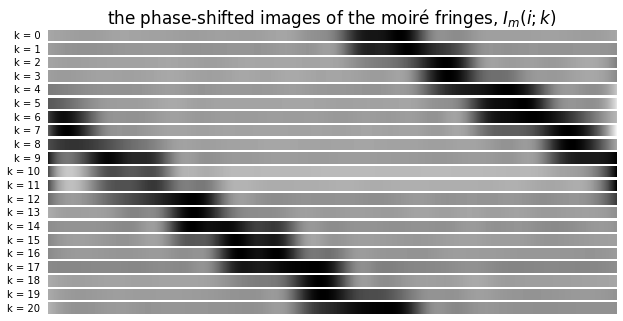

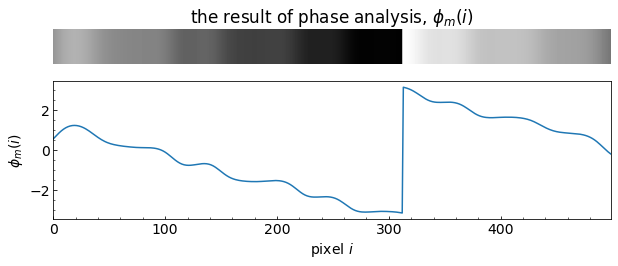

In [13]:
phi_H = LineprofileToPhase(np.mean(im_Htrim, axis=0), SamplingPitch_H, allplotTF)

位相差

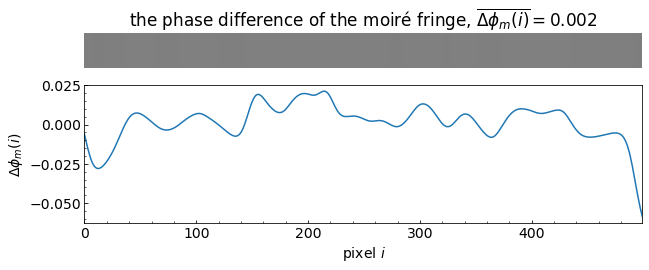

In [15]:
img = ["TestImage/IMG_27"+str(n)+".jpg" for n in range(79,88)]
FC601 = [0,2.07,4.13,10.19,15.19,27.02,42.085,104.39,0.01]

((unmove_phi_H,unmove_phi_V),GratingPich,SamplingPitch) = ImageToPhase(
    img[0], rotateTF, (centerX, centerY), (lengthX, lengthY),
    linewidth, GaussConst, (0,0), (0,0), 0)

H_Displacement = []
V_Displacement = []
for img_i in img:
    ((move_phi_H,move_phi_V),_,_) = ImageToPhase(
        img_i, rotateTF, (centerX, centerY), (lengthX, lengthY), 
        linewidth, GaussConst, GratingPich, SamplingPitch, 0)
    H_Displacement.append(PhaseToDisplacement(unmove_phi_H, move_phi_H, GratingPich[0], 0))
    V_Displacement.append(PhaseToDisplacement(unmove_phi_V, move_phi_V, GratingPich[1], 0))

temp = PhaseToDisplacement(unmove_phi_H, move_phi_H, GratingPich[0], allplotTF)
# print(H_Displacement)

,FC-601 [um],horizontal,verticality
TestImage/IMG_2779.jpg,0.000,0.000000,0.000000
TestImage/IMG_2780.jpg,2.070,-0.110610,-0.229710
TestImage/IMG_2781.jpg,4.130,-0.165880,-0.223669
TestImage/IMG_2782.jpg,10.190,-0.423276,-0.310610
TestImage/IMG_2783.jpg,15.190,-0.616513,-0.337775
TestImage/IMG_2784.jpg,27.020,-1.231721,-0.318214
TestImage/IMG_2785.jpg,42.085,-1.767276,-0.353885
TestImage/IMG_2786.jpg,104.390,-4.419869,-0.369669
TestImage/IMG_2787.jpg,0.010,0.021784,-0.365685


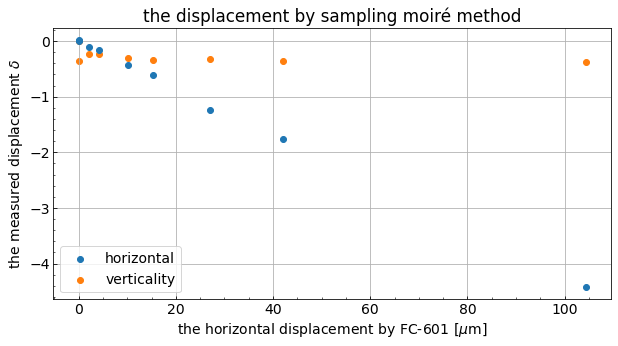

In [16]:
if allplotTF:
    df = pd.DataFrame([FC601,H_Displacement,V_Displacement]).T
    df.columns = ['FC-601 [um]', 'horizontal', 'verticality']
    df.index = img
    display(df)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title('the displacement by sampling moiré method')
    ax.scatter(FC601, H_Displacement ,label="horizontal",  zorder=2)
    ax.scatter(FC601, V_Displacement ,label="verticality",  zorder=1)
    plt.grid(True, which="major", linestyle="-")
    ax.set_xlabel('the horizontal displacement by FC-601 [$\mu$m]')
    ax.set_ylabel('the measured displacement $\delta$')
    ax.legend()
    plt.show()